## Canny Edge Detector

This is the implementation of **Canny Edge Detector** from scratch using NumPy with interactive GUI in Python. Following are the steps:

1. Noise reduction
2. Gradient calculation
3. Non-Maximum Suppression
4. Double threshold
5. Edge tracking by Hysteresis

**Sample Output 1:**

![Output 1](images/output_1.jpg)

**Sample Output 2:**

![Output 2](images/output_2.jpg)

**Sample Output 3:**

![Output 3](images/output_3.jpg)

In [1]:
"""
@author: Saurabh Chatterjee
"""

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import cv2

In [29]:
# Gaussian Filter:

def gaussian_kernel(size, sigma=1):
    size = int(size)  //2
    x, y = np.mgrid[-size:size+1, -size:size+1]     # return coordinate matrices `x` and `y`, BOTH of **SAME DIMENSION** = No. of indexing dimensions, from coordinate **indices** given for each dimension
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal     # 2-D Gaussian | mean, u = 0 taken
    return g

In [30]:
# Sobel Edge/Gradient Detection:

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)        # Gradient Magnitude
    G = G / G.max() * 255       # Normalize

    theta = np.arctan2(Iy, Ix)  # Gradient Vector Direction     | 4-Quadrant Inverse-Tangent
    
    return (G, theta)

In [31]:
# Non-Max Suppression - to thin out the edges:

def non_max_suppression(img_grad, theta):
    M, N = img_grad.shape
    Z = np.zeros((M,N), dtype=np.int32)

    angle = theta * 180. / np.pi    
    angle[angle < 0] += 180     # to categorise opposite directions into same category **

    for i in range(1, M-1):
        for j in range(1, N-1):
                try:
                    q = 255
                    r = 255

                    #angle 0:
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img_grad[i, j+1]
                        r = img_grad[i, j-1]
                    #angle 45:
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img_grad[i+1, j-1]
                        r = img_grad[i-1, j+1]
                    #angle 90:
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img_grad[i+1, j]
                        r = img_grad[i-1, j]
                    #angle 135:
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img_grad[i-1, j-1]
                        r = img_grad[i+1, j+1]

                    if (img_grad[i,j] >= q) and (img_grad[i,j] >= r):   # if grad at (i, j) is more than both one back and one front coord in the theta direction: Consider this grad value
                        Z[i,j] = img_grad[i,j]
                    else:                                               # else reject this grad, i.e. assign it 0 grad
                        Z[i,j] = 0
                
                except IndexError as e:
                    pass

    return Z

In [32]:
# Double Thresholding - categorise each pixel into three categories:
# Strong (grad >= highThreshold) | Weak (highThreshold >= grad >= lowThreshold) | Non-Relavant (grad < lowThreshold):

def threshold(img, lowThreshold, highThreshold):
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = 25
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

In [33]:
# Hysteresis: transforming weak pixels into strong ones, if and only if at least one of the pixels around (3x3) the one being processed is a strong one

def hysteresis(img, weak, strong=255):
    M, N = img.shape

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):          # For EACH WEAK Grad Pixel:
                try:                        # if at least 1 in 3x3 neighbourhood is Strong -> (set this Grad = Strong = 255) **
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0       # Else -> (set Grad = 0) **
                except IndexError as e:
                    pass
                
    return img

In [34]:
def plot(image, image_edge):
    plt.subplot(121)
    plt.imshow(image, cmap = 'gray')
    plt.title("ORIGINAL")

    plt.subplot(122)
    plt.imshow(image_edge, cmap= 'gray')
    plt.title("CANNY EDGES")
    
    plt.show()

In [39]:
def canny(img, low, high, kernel_size=5, sigma=1):

    img_arr = np.asarray(img, np.float64)   

    g = gaussian_kernel(kernel_size, sigma)
    img_smoothed = ndimage.convolve(img_arr, g)
    grad, theta = sobel_filters(img_smoothed)
    img_grad = non_max_suppression(grad, theta)

    img_grad_2, weak, strong = threshold(img_grad, low, high)
    img_grad_3 = hysteresis(img_grad_2, weak, strong)
    
    # print(img_grad_3.dtype)
    # plot(img, img_grad_3)

    return img_grad_3

int32


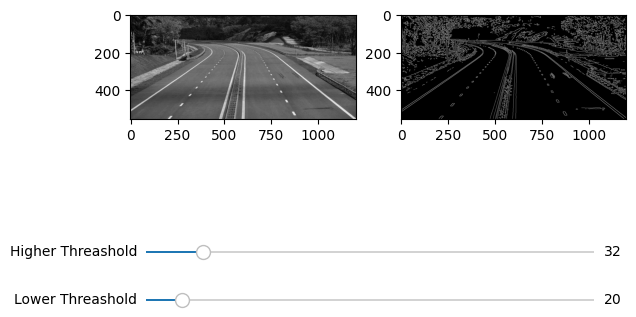

In [41]:
fig = plt.figure()
fig.subplots_adjust(bottom=0.3)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Load Image:
img = cv2.imread('images/Lanes.jpg', 0) 

img_grad_3 = canny(img, 20, 32)

im1 = ax1.imshow(img, cmap='gray')
im2 = ax2.imshow(img_grad_3, cmap='gray')


# Create 2 axes for 2 sliders:
axes_slider1 = fig.add_axes([0.25,0.1,0.7,0.01])
axes_slider2 = fig.add_axes([0.25,0.2,0.7,0.01])
axes_slider3 = fig.add_axes([0.25,0.3,0.7,0.01])

slider1 = Slider(axes_slider1, "Lower Threshold", 0, 255, valinit=20)
slider2 = Slider(axes_slider2, "Higher Threshold", 0, 255, valinit=30)
slider3 = Slider(axes_slider3, "Gaussian Kernel Size", 3, 11, valstep=2, valinit=5)     # only ODD values



def update(val):
	print(f's1= {slider1.val}')
	print(f's2= {slider2.val}')
	img_grad_3 = canny(img, slider1.val, slider2.val, kernel_size=slider3.val)
	im1.set_data(img)
	im2.set_data(img_grad_3)

	fig.canvas.draw_idle()

slider1.on_changed(update)
slider2.on_changed(update)
slider3.on_changed(update)

plt.show()